In [49]:
import scanpy as sc
import numpy as np
import surgeon

In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas Celseq", "Pancreas CelSeq2"]
target_cell_types = ['Pancreas Alpha']

# Loading 5 Pancreas datasets and data preparation

In [4]:
adata = sc.read("./data/pancreas/pancreas_count.h5ad")
adata

AnnData object with n_obs × n_vars = 15921 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8569
Pancreas SS2            2989
Pancreas CelSeq2        2449
Pancreas Celseq         1276
Pancreas Fluidigm C1     638
Name: study, dtype: int64

## visualization  of the original data

In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


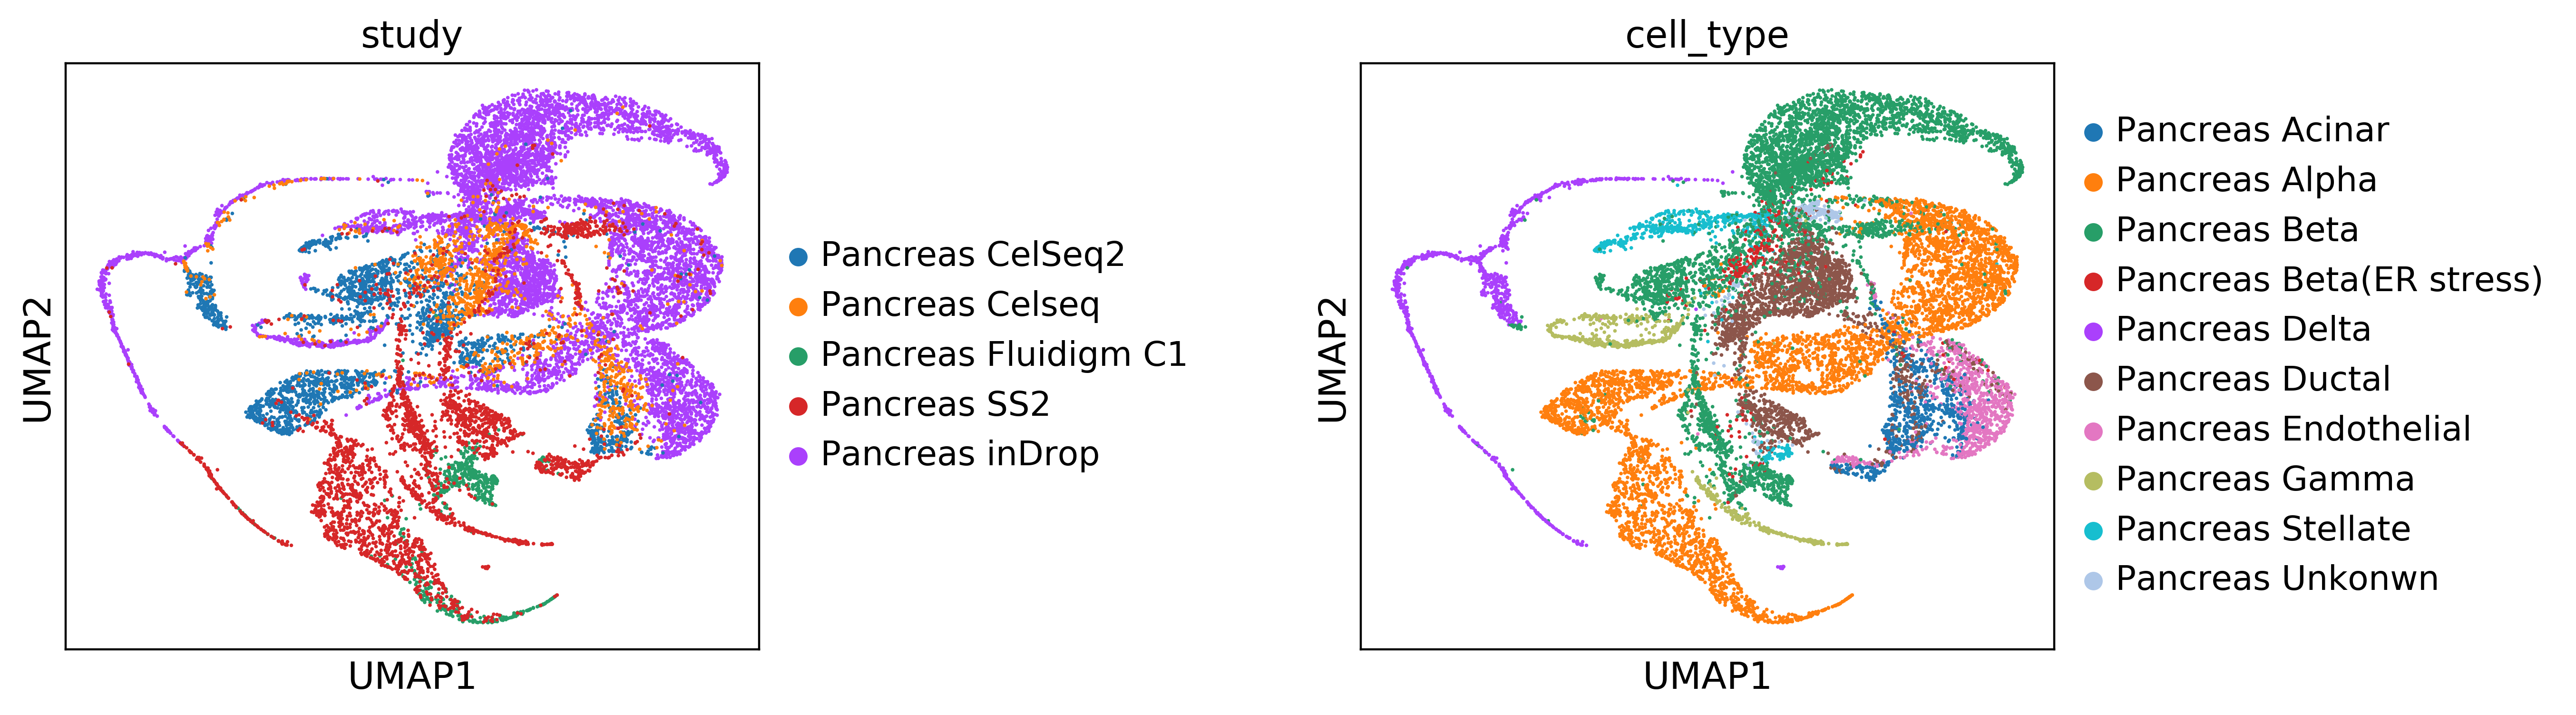

In [10]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.7)

## Now we leave out one study (SS2) for training the newtork

In [6]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 12196 × 15369 
    obs: 'batch', 'study', 'cell_type'

In [7]:
adata_for_training = adata_for_training[~adata_for_training.obs[cell_type_key].isin(target_cell_types)]
adata_for_training

View of AnnData object with n_obs × n_vars = 8597 × 15369 
    obs: 'batch', 'study', 'cell_type'

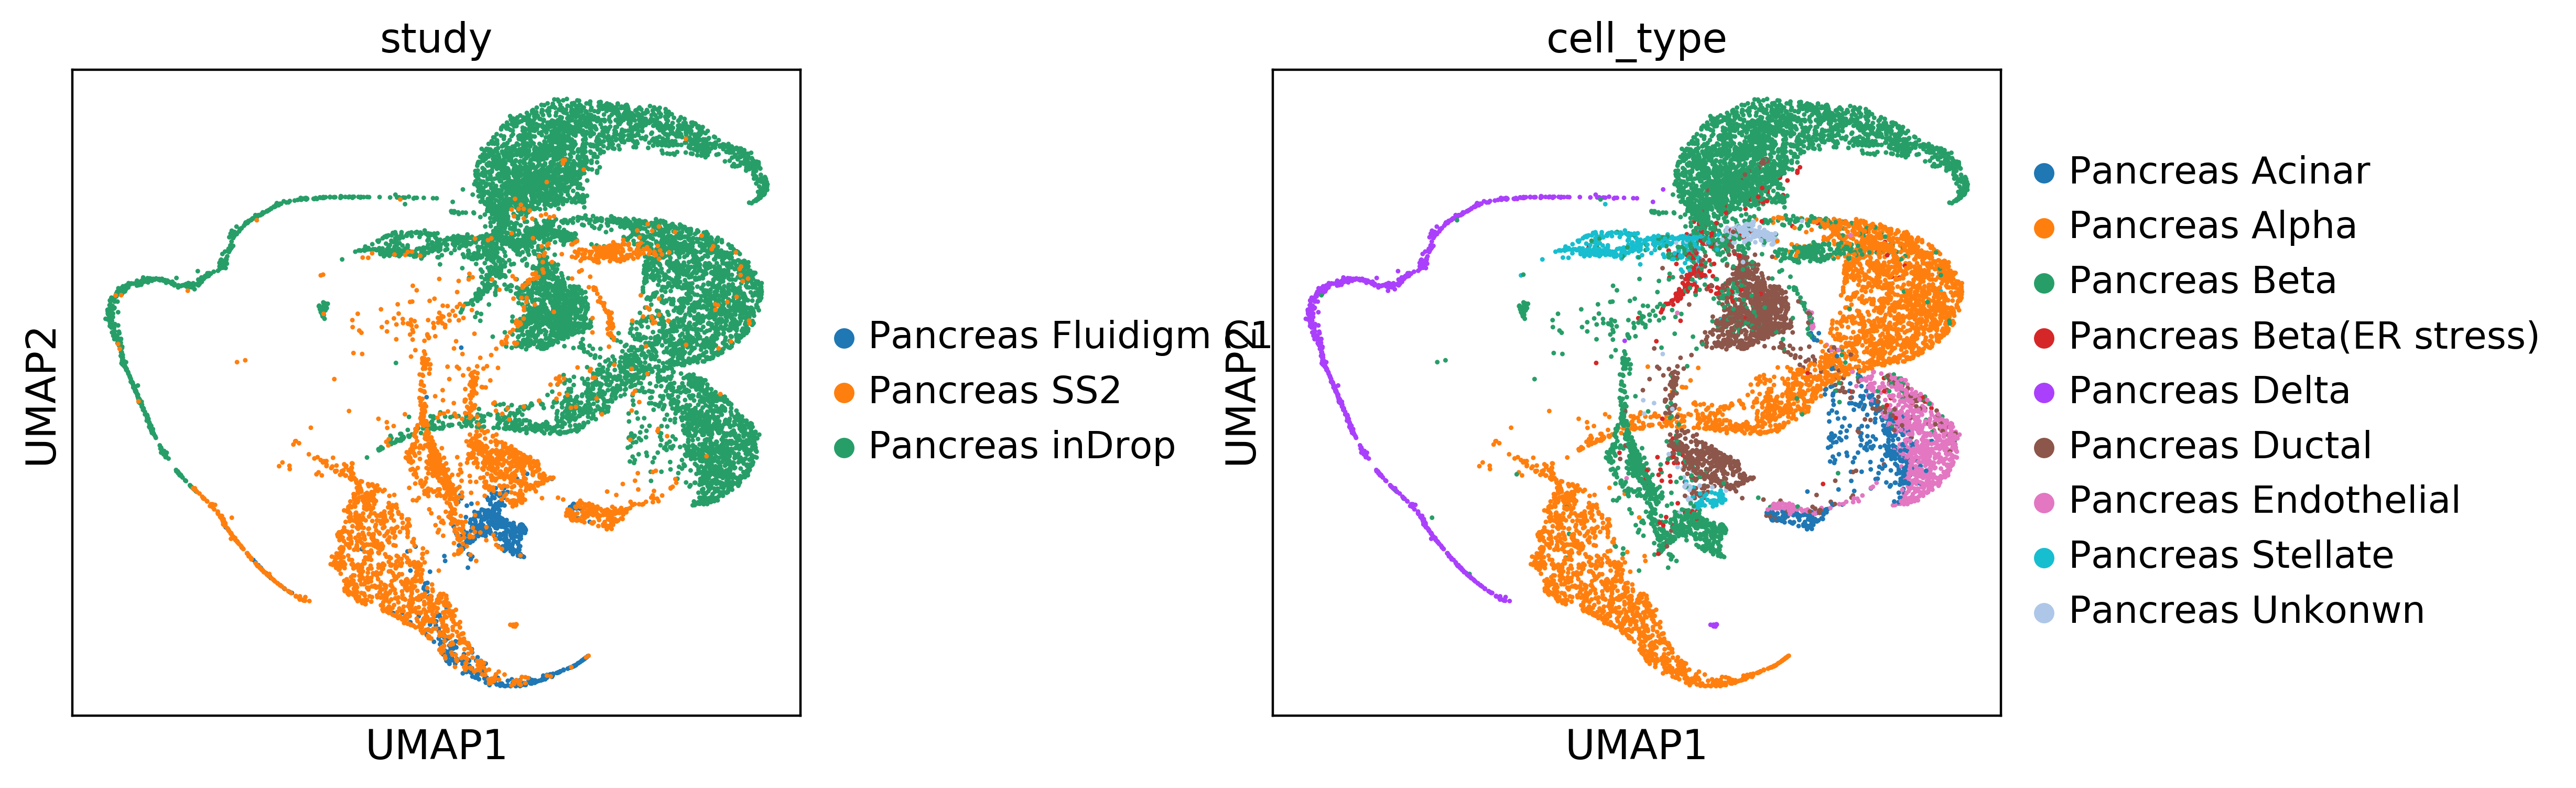

In [14]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [8]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 3725 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Normalization

In [9]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=5000,
                                            )

Trying to set attribute `.obs` of view, making a copy.


In [10]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=5000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [11]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [12]:
train_adata.shape, valid_adata.shape

((7307, 5000), (1290, 5000))

In [13]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [14]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=40,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             scale_factor=10.0,
                             clip_value=3.0,
                             loss_fn='nb',
                             model_path=f"./models/OutOfSample/Before-Pancreas-{target_cell_types[0]}/",
                             dropout_rate=0.2,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 5000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 5003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          2561536     concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [15]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas SS2': 2}

## Training the network

In [16]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              batch_size=32, 
              early_stop_limit=50,
              lr_reducer=35, 
              n_per_epoch=0,
              save=True, 
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 7307 samples, validate on 1290 samples
Epoch 1/1000
 - 4s - loss: 0.7796 - nb: 0.7796 - val_loss: 0.6817 - val_nb: 0.6817
Epoch 2/1000
 - 2s - loss: 0.6827 - nb: 0.6827 - val_loss: 0.6686 - val_nb: 0.6686
Epoch 3/1000
 - 2s - loss: 0.6736 - nb: 0.6736 - val_loss: 0.6678 - val_nb: 0.6678
Epoch 4/1000
 - 2s - loss: 0.6696 - nb: 0.6696 - val_loss: 0.6613 - val_nb: 0.6613
Epoch 5/1000
 - 2s - loss: 0.6663 - nb: 0.6663 - val_loss: 0.6587 - val_nb: 0.6587
Epoch 6/1000
 - 2s - loss: 0.6642 - nb: 0.6642 - val_loss: 0.6569 - val_nb: 0.6569
Epoch 7/1000
 - 2s - loss: 0.6624 - nb: 0.6624 - val_loss: 0.6591 - val_nb: 0.6591
Epoch 8/1000
 - 2s - loss: 0.6607 - nb: 0.6607 - val_loss: 0.6569 - val_nb: 0.6569
Epoch 9/1000
 - 2s - loss: 0.6601 - nb: 0.6601 - val_loss: 0.6569 - val_nb: 0.6569
Epoch 10/1000
 - 2s - loss: 0.6584 - nb: 0.6584 - val_loss: 0.6537 - val_nb: 0.6537
Epoch 11/1000
 - 2s - loss: 0.6578 - nb: 0.6578 - val_loss: 0.6561 - val_

In [17]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas SS2': 2}

In [18]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [19]:
latent_adata = network.to_latent(adata_for_training, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8597 × 40 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [20]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

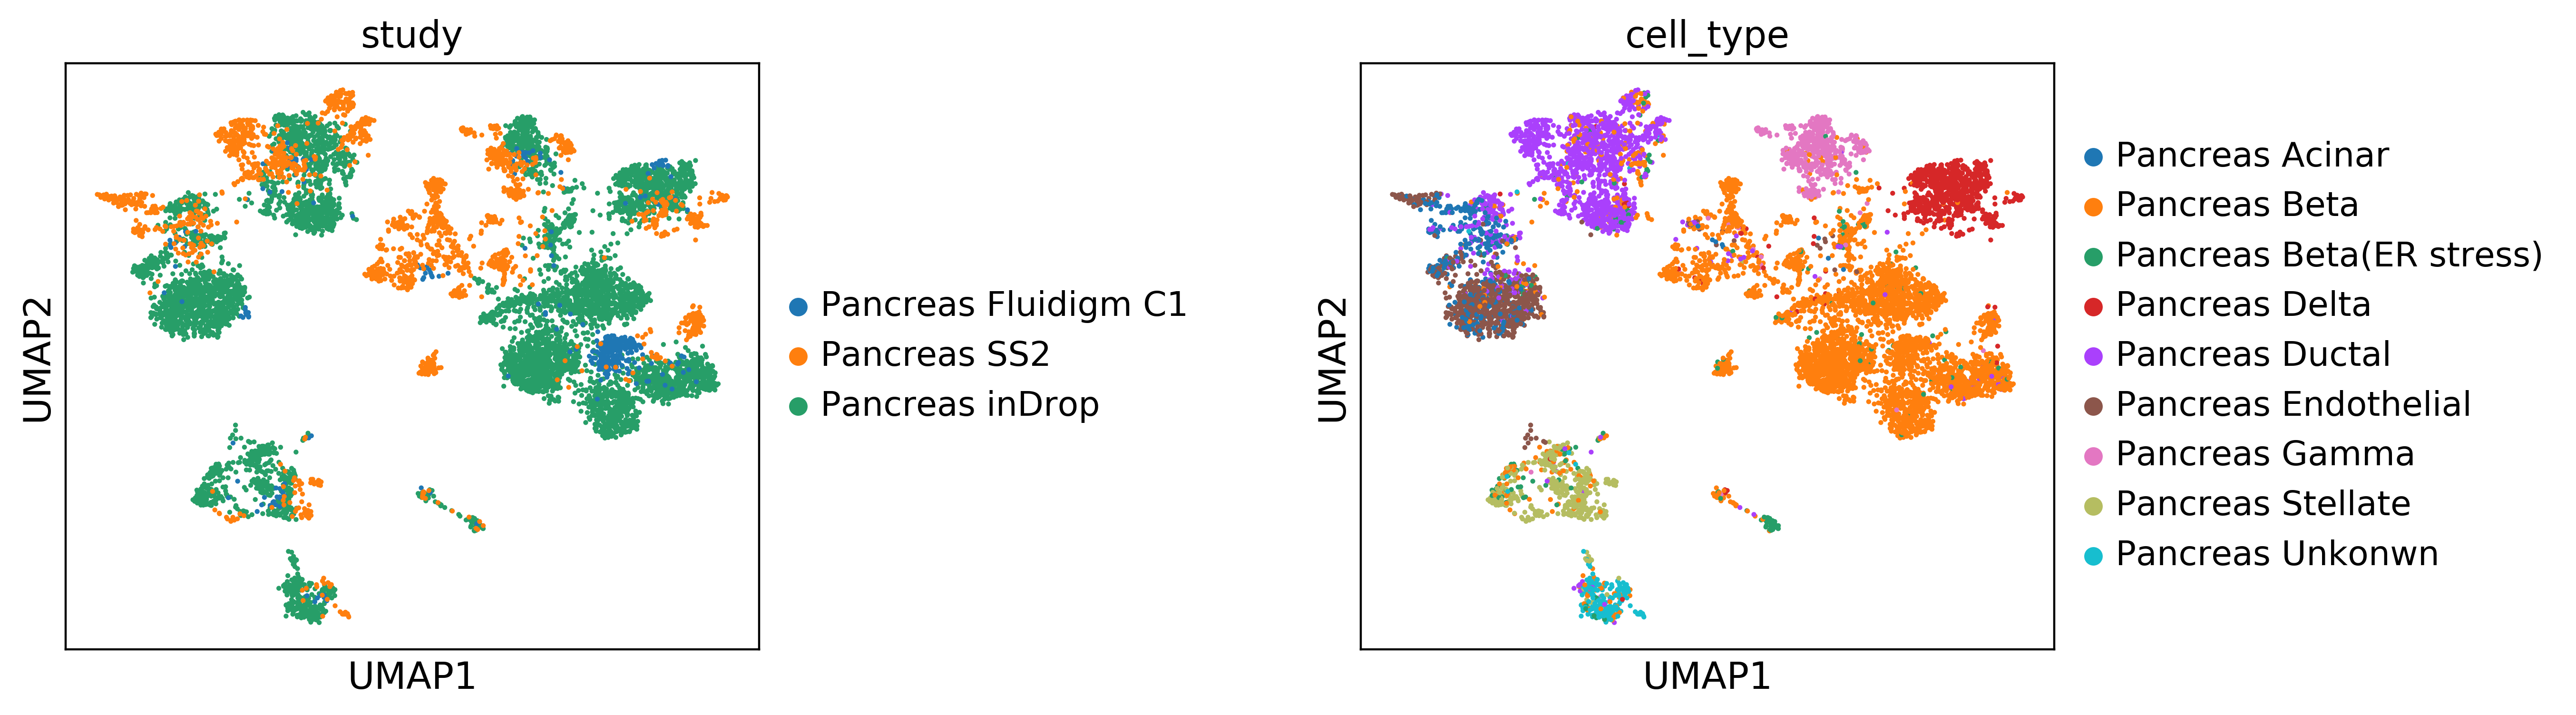

In [22]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.7)

# Perfroming architecture Surgery

In [23]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 5000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 5005)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          2562560     concatenate_3[0][0]              
__________

In [24]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas Fluidigm C1': 1,
 'Pancreas SS2': 2,
 'Pancreas Celseq': 3,
 'Pancreas CelSeq2': 4}

## Train with small new dataset containing out-of-sample condition

In [25]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [26]:
train_adata.shape, valid_adata.shape

((3166, 5000), (559, 5000))

In [27]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=300,
                  batch_size=32, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  n_per_epoch=0,
                  save=True, 
                  verbose=2)

Train on 3166 samples, validate on 559 samples
Epoch 1/300
 - 2s - loss: 1.6947 - nb: 1.6947 - val_loss: 1.2975 - val_nb: 1.2975
Epoch 2/300
 - 1s - loss: 1.4561 - nb: 1.4561 - val_loss: 1.2384 - val_nb: 1.2384
Epoch 3/300
 - 1s - loss: 1.3790 - nb: 1.3790 - val_loss: 1.1750 - val_nb: 1.1750
Epoch 4/300
 - 1s - loss: 1.3291 - nb: 1.3291 - val_loss: 1.1551 - val_nb: 1.1551
Epoch 5/300
 - 1s - loss: 1.2948 - nb: 1.2948 - val_loss: 1.1886 - val_nb: 1.1886
Epoch 6/300
 - 1s - loss: 1.2636 - nb: 1.2636 - val_loss: 1.1654 - val_nb: 1.1654
Epoch 7/300
 - 1s - loss: 1.2464 - nb: 1.2464 - val_loss: 1.1720 - val_nb: 1.1720
Epoch 8/300
 - 1s - loss: 1.2367 - nb: 1.2367 - val_loss: 1.1564 - val_nb: 1.1564
Epoch 9/300
 - 1s - loss: 1.2208 - nb: 1.2208 - val_loss: 1.1851 - val_nb: 1.1851
Epoch 10/300
 - 1s - loss: 1.2109 - nb: 1.2109 - val_loss: 1.1916 - val_nb: 1.1916
Epoch 11/300
 - 1s - loss: 1.1969 - nb: 1.1969 - val_loss: 1.1375 - val_nb: 1.1375
Epoch 12/300
 - 1s - loss: 1.1934 - nb: 1.1934 - 

In [28]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(3725, 1)

In [29]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 3725 × 40 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [30]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

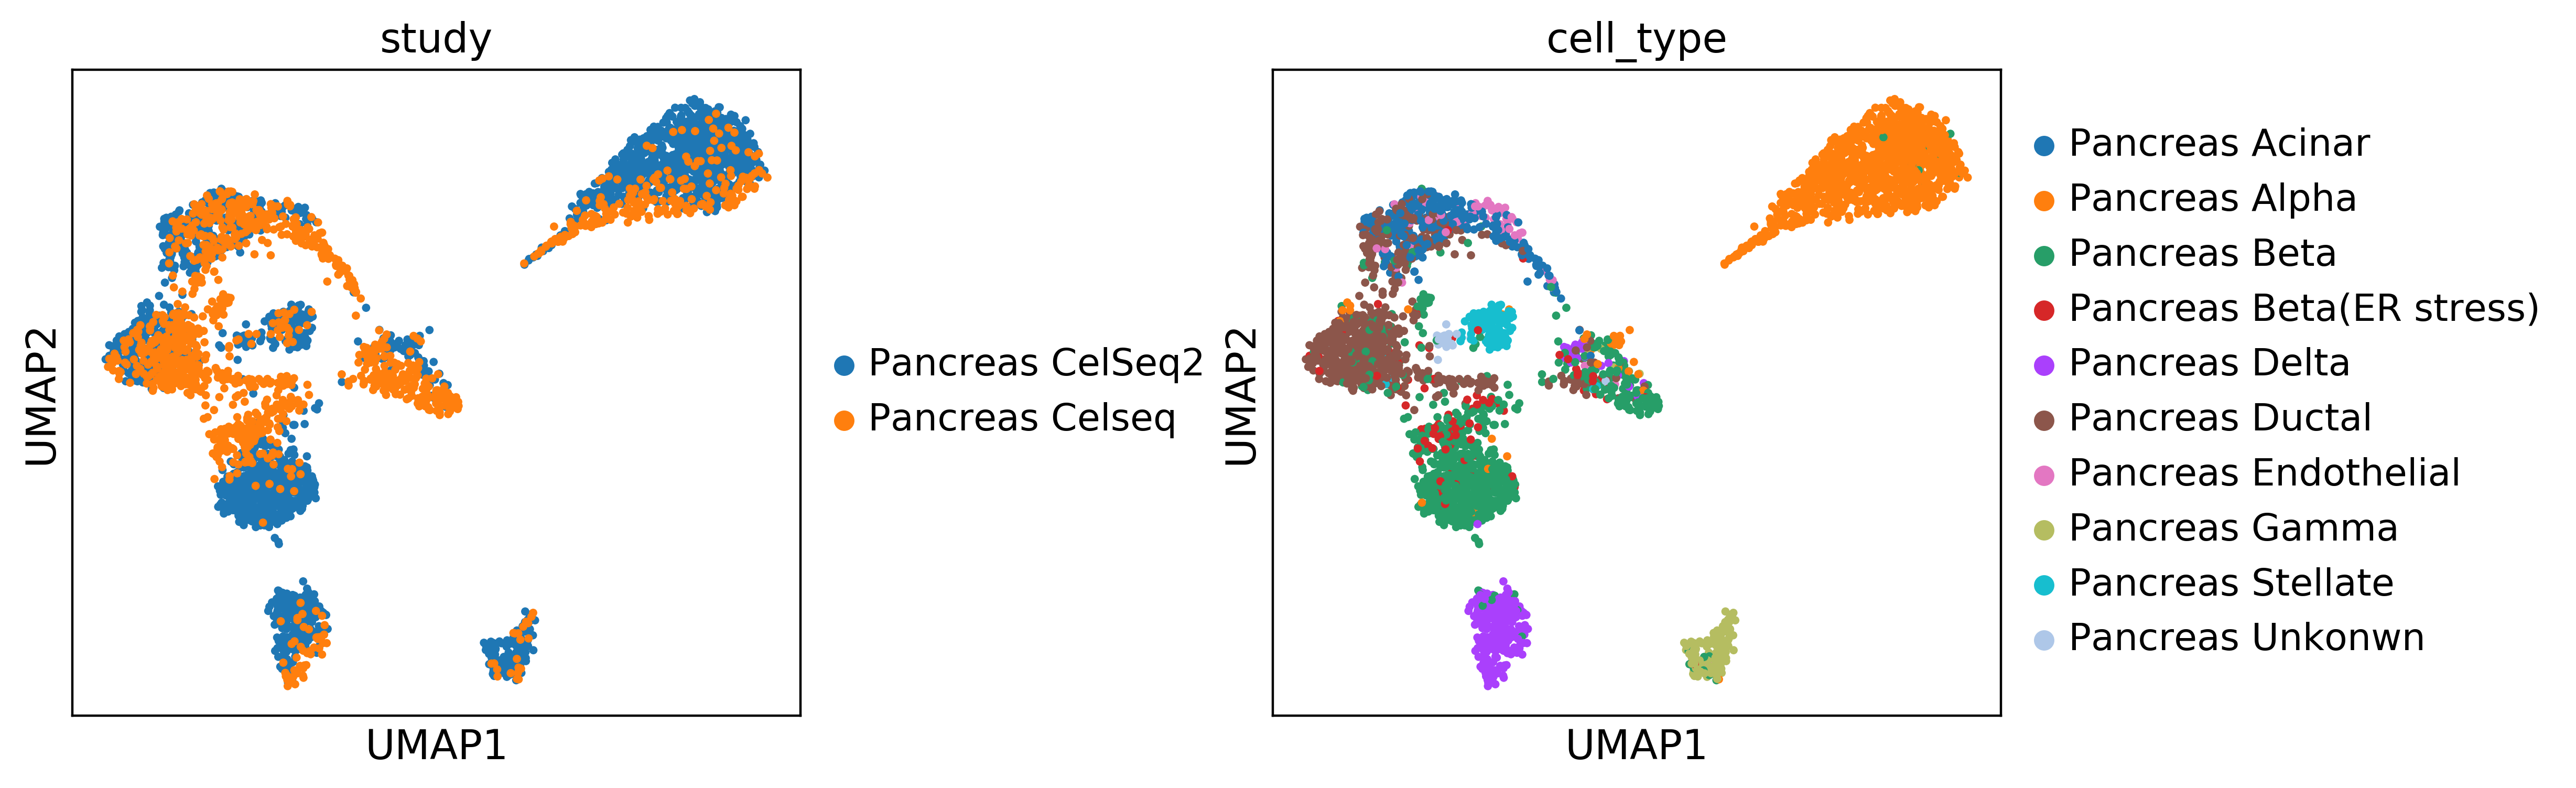

In [31]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Let's see what has happened for the target cell type! :)

In [32]:
adata = surgeon.utils.normalize(adata, 
                                 filter_min_counts=False, 
                                 normalize_input=False, 
                                 size_factors=True,
                                 logtrans_input=True,
                                 n_top_genes=5000,
                                )

In [33]:
adata

AnnData object with n_obs × n_vars = 15921 × 5000 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [46]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(15921, 1)

In [35]:
adata.obs[cell_type_key].value_counts()

Pancreas Beta               4765
Pancreas Alpha              4704
Pancreas Ductal             2104
Pancreas Delta              1041
Pancreas Endothelial         836
Pancreas Acinar              713
Pancreas Gamma               637
Pancreas Stellate            561
Pancreas Beta(ER stress)     320
Pancreas Unkonwn             240
Name: cell_type, dtype: int64

In [36]:
adata.obs['cell_label'] = 'others'
adata.obs.loc[((adata.obs[cell_type_key].isin(target_cell_types))), 'cell_label'] = target_cell_types[0]

In [37]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 15921 × 40 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors', 'cell_label'

In [38]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

... storing 'cell_label' as categorical


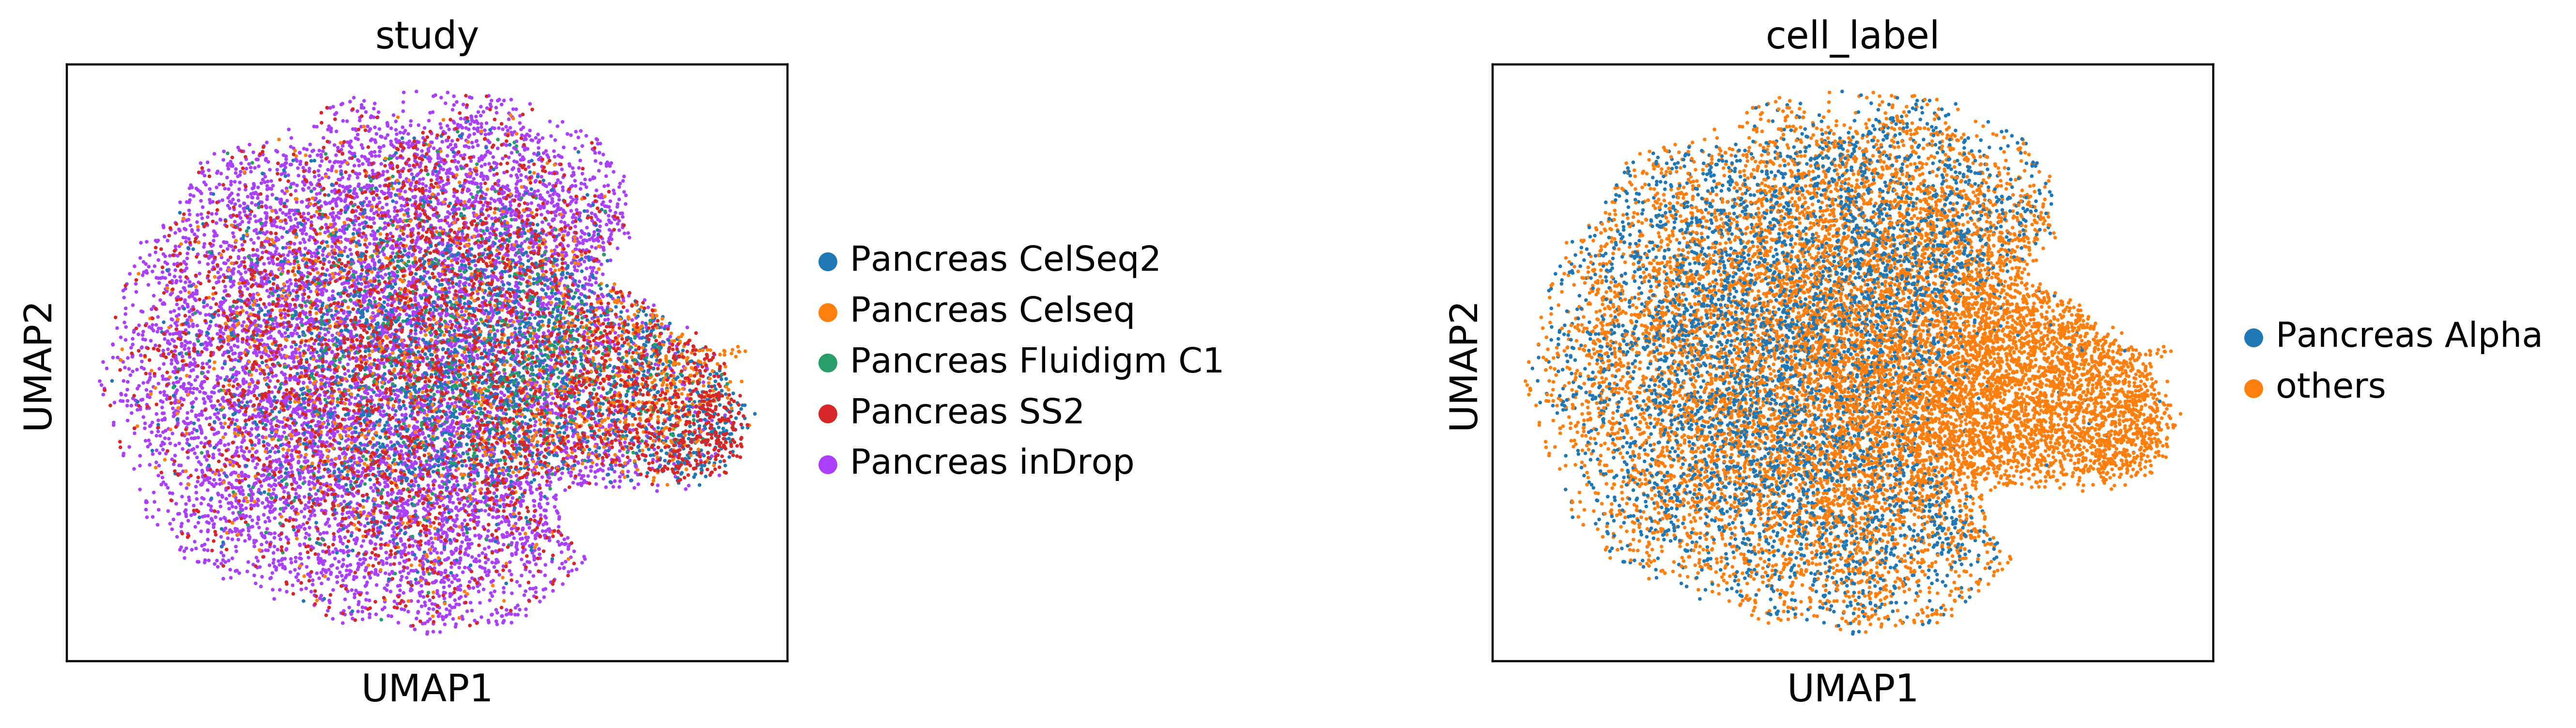

In [39]:
sc.pl.umap(latent_adata, color=[condition_key, "cell_label"], wspace=0.8)